In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import healpy as hp
import fitsio as ft
import numpy as np

import matplotlib.backends.backend_pdf

import sys
sys.path.append('/home/mehdi/github/LSSutils')
import LSSutils.dataviz as dv

from LSSutils.io import readnbodykit
from LSSutils.utils import (hpixsum, shiftra, 
                            steradian2sqdeg, hpix2radec, overdensity)

camb is not installed!


In [2]:
plt.rc('font', family='serif', size=12)

# Mollweide

In [36]:
dNGC = ft.read('/home/mehdi/data/eboss/v7_2/0.2/eBOSS_QSO_clustering_NGC_v7_2_0.2.dat.fits')
rNGC = ft.read('/home/mehdi/data/eboss/v7_2/0.2/eBOSS_QSO_clustering_NGC_v7_2_0.2.ran.fits')

dSGC = ft.read('/home/mehdi/data/eboss/v7_2/0.2/eBOSS_QSO_clustering_SGC_v7_2_0.2.dat.fits')
rSGC = ft.read('/home/mehdi/data/eboss/v7_2/0.2/eBOSS_QSO_clustering_SGC_v7_2_0.2.ran.fits')

data = np.concatenate([dNGC, dSGC])
random = np.concatenate([rNGC, rSGC])

nside  = 64
hpmap0  = hpixsum(nside,  data['RA'], data['DEC'],
                 value=data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ'])
hpmap1  = hpixsum(nside,  data['RA'], data['DEC'],
                 value=data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ']*data['WEIGHT_SYSTOT'])
hpmapr = hpixsum(nside, random['RA'], random['DEC'], 
                 value=random['WEIGHT_CP']*random['WEIGHT_FKP']*random['WEIGHT_NOZ']*random['WEIGHT_SYSTOT'])

mask = hpmapr != 0
meanran = np.mean(hpmapr[mask])
frac = hpmapr / meanran


hpmap0[~mask] = np.nan
hpmap1[~mask] = np.nan
density1 = hpmap1/(frac*hp.nside2pixarea(nside, degrees=True))
density0 = hpmap0/(frac*hp.nside2pixarea(nside, degrees=True))



fsky = np.mean(frac)
print(f'total area {steradian2sqdeg(fsky*4*np.pi)}, fsky : {fsky}')

total area 5723.143366694947, fsky : 0.13873291015625


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


In [25]:
hp.nside2resol(64, arcmin=True)

54.967782589078496

In [26]:
import pandas as pd

In [28]:
df = pd.read_hdf('/home/mehdi/data/templates/SDSS_WISE_HI_imageprop_nside512.h5', 'templates')

In [39]:
ebv = hp.ud_grade(df.ebv, nside_out=64)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [40]:
ebv[~mask]= np.nan

In [46]:
np.percentile(ebv[mask & ~np.isnan(ebv)], [10, 90])

array([0.01174716, 0.07652191])

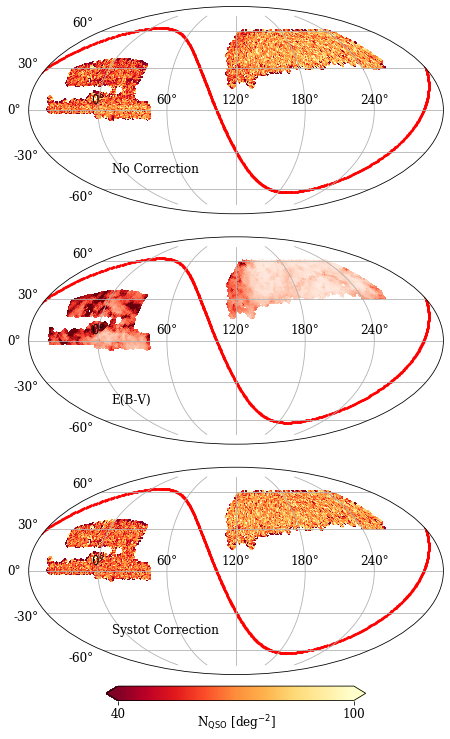

In [58]:
fig = plt.figure(figsize=(6, 10))
# matplotlib is doing the mollveide projection
ax  = fig.add_subplot(311, projection='mollweide')
ax1 = fig.add_subplot(312, projection='mollweide')
ax2 = fig.add_subplot(313, projection='mollweide')
spacing = 0.02
plt.subplots_adjust(bottom=spacing, top=1-spacing, 
                    left=spacing, right=1-spacing,
                    hspace=0.0)
kw = dict(unit=r'N$_{{\rm QSO}}$ [deg$^{-2}$]', cmap=plt.cm.YlOrRd_r, 
         vmin=40, vmax=100, #width=6, 
         extend='both', galaxy=True)

dv.mollview(density0, figax=[fig, ax], **kw)
dv.mollview(ebv, figax=[fig, ax1], galaxy=True, vmin=0, 
            vmax=0.1, cmap=plt.cm.Reds, unit='')
dv.mollview(density1, figax=[fig, ax2], colorbar=True, **kw)

ax.text(0.2, 0.2, 'No Correction', transform=ax.transAxes)
ax1.text(0.2, 0.2, 'E(B-V)', transform=ax1.transAxes)
ax2.text(0.2, 0.2, 'Systot Correction', transform=ax2.transAxes)
plt.savefig('./figs/qso_p2_nside64.pdf', bbox_inches='tight', dpi=300, rasterized=True)

In [37]:
#---
gmask = (dNGC['Z'] > 3.2) & (dNGC['Z'] < 3.5)
rmask = (rNGC['Z'] > 3.2) & (rNGC['Z'] < 3.5)
#--- 
gmask1 = (dNGC['Z'] > 3.0) & (dNGC['Z'] < 3.2)
rmask1 = (rNGC['Z'] > 3.0) & (rNGC['Z'] < 3.2)

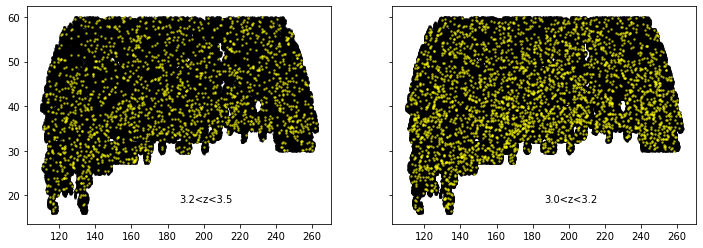

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

labels = ['3.2<z<3.5', '3.0<z<3.2']
i = 0
for (g_i, r_i) in zip([gmask, gmask1], [rmask, rmask1]):
    
    # --- 
    ax[i].scatter(rNGC['RA'][r_i], rNGC['DEC'][r_i], 
                10, color='k', marker='.', alpha=0.5)
    ax[i].scatter(dNGC['RA'][g_i], dNGC['DEC'][g_i], 
                10, color='yellow', marker='.', alpha=0.5)
    ax[i].text(0.5, 0.1, labels[i], transform=ax[i].transAxes)
    i += 1

# N(z)

In [5]:
!head -n 3 /home/mehdi/data/eboss/v7_2/nbar_eBOSS_QSO_*GC_v7_2.dat

==> /home/mehdi/data/eboss/v7_2/nbar_eBOSS_QSO_NGC_v7_2.dat <==
# effective area (deg^2), effective volume (Mpc/h)^3: 2860.4406814189183 99740127.64438488
# zcen,zlow,zhigh,nbar,wfkp,shell_vol,total weighted gals
0.005 0.0 0.01 0.00013462213635665303 0.5976890894834057 7771.038808820277 1.046153846153846

==> /home/mehdi/data/eboss/v7_2/nbar_eBOSS_QSO_SGC_v7_2.dat <==
# effective area (deg^2), effective volume (Mpc/h)^3: 1838.8730140161808 53674436.18509478
# zcen,zlow,zhigh,nbar,wfkp,shell_vol,total weighted gals
0.005 0.0 0.01 0.00020558148614182404 0.4931191556659562 4995.717495292908 1.027027027027027


In [6]:
2860.4406814189183 + 1838.8730140161808

4699.313695435099

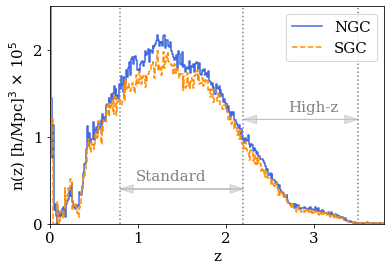

In [78]:
plt.rc('font', family='serif', size=15)

nbar_ngc = np.loadtxt('/home/mehdi/data/eboss/v7_2/nbar_eBOSS_QSO_NGC_v7_2.dat')
nbar_sgc = np.loadtxt('/home/mehdi/data/eboss/v7_2/nbar_eBOSS_QSO_SGC_v7_2.dat')


fig, ax = plt.subplots(figsize=(6, 4))

kw = dict(where='mid')
ax.step(nbar_ngc[:,0], nbar_ngc[:, 3]/1.0e-5, label='NGC', ls='-', color='royalblue', **kw)
ax.step(nbar_sgc[:,0], nbar_sgc[:, 3]/1.0e-5, label='SGC', ls='--', color='darkorange', **kw)

samples = ['Standard', 'High-z']
lines  = [0.8, 2.2, 3.5]
for i, line in enumerate(lines):
    ax.axvline(line, zorder=0, ls=':', color='grey')
    
    if i<2:
        #-- annotation
        if i==0:
            ypos = 0.5
        else:
            ypos = 1.3
            
        ax.text(1.23*line, ypos, samples[i], color='grey')
        
        hwidth=0.1
        width=0.001
        kw = dict(shape='full', width=width, 
                  head_width=hwidth, color='grey', alpha=0.25)  
        
        # left to right
        ax.arrow(lines[i], ypos-0.1, lines[i+1]-lines[i]-1.5*hwidth, 0.0, **kw)        
        # right to left
        ax.arrow(lines[i+1], ypos-0.1, -lines[i+1]+lines[i]+1.5*hwidth, 0.0, **kw) 


ax.set(xlabel='z', ylabel=r'n(z) [h/Mpc]$^{3}$ $\times$ 10$^{5}$',
       ylim=(0.0, 2.5), xlim=(0.0, 3.8), yticks=[0.0, 1.0, 2.0]) #yscale='log', 
# ax.grid(True, ls=':', color='grey', which='both')
ax.legend()
fig.savefig('figs/nz.pdf', bbox_inches='tight')

# Selection masks

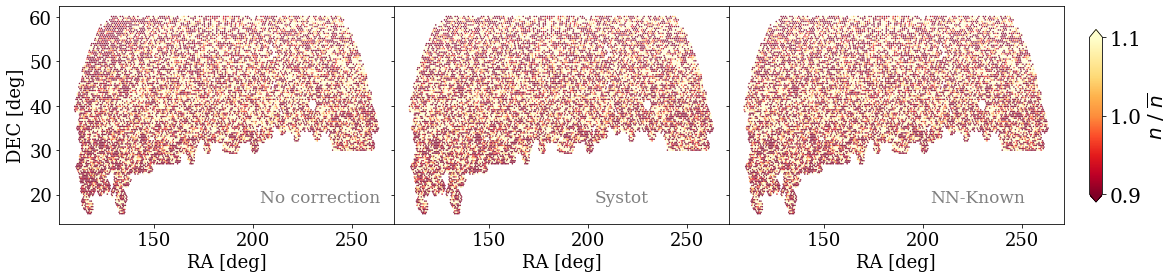

In [3]:
# ---- read data and random
data = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3.dat.fits')
random = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3.ran.fits')

data_nn = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3_known_allhigh.dat.fits')
random_nn = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3_known_allhigh.ran.fits')



#---- project to HEALPIX
nside  = 128
# hp.nside2resol(nside, arcmin=True)
# 27.483891294539248

hpmaps = {}

# data 
weight = data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ']
hpmaps['ngal_none'] = hpixsum(nside,  data['RA'], data['DEC'], value=weight)
hpmaps['ngal_systot'] = hpixsum(nside,  data['RA'], data['DEC'], value=weight*data['WEIGHT_SYSTOT'])

weightr = random['WEIGHT_CP']*random['WEIGHT_FKP']*random['WEIGHT_NOZ']*random['WEIGHT_SYSTOT']
hpmaps['nran_systot'] = hpixsum(nside,  random['RA'], random['DEC'], value=weightr)

weight_nn = data_nn['WEIGHT_CP']*data_nn['WEIGHT_FKP']*data_nn['WEIGHT_NOZ']
hpmaps['ngal_nn'] = hpixsum(nside,  data_nn['RA'], data_nn['DEC'], value=weight_nn*data_nn['WEIGHT_SYSTOT'])

weightr_nn = random_nn['WEIGHT_CP']*random_nn['WEIGHT_FKP']*random_nn['WEIGHT_NOZ']*random_nn['WEIGHT_SYSTOT']
hpmaps['nran_nn'] = hpixsum(nside,  random_nn['RA'], random_nn['DEC'], value=weightr_nn)


#---- using Randoms, compute the N/Nbar
# makedelta returns overdensity, we add 1 back to get N/Nbar
deltas = {}
deltas['none'] = overdensity(hpmaps['ngal_none'], hpmaps['nran_systot'], hpmaps['nran_systot']>0) + 1
deltas['systot'] = overdensity(hpmaps['ngal_systot'], hpmaps['nran_systot'], hpmaps['nran_systot']>0) + 1
deltas['nn'] = overdensity(hpmaps['ngal_nn'], hpmaps['nran_nn'], hpmaps['nran_nn']>0) + 1

# np.array_equal(hpmaps['nran_nn']>0, hpmaps['nran_systot']>0)
# True
hpix = np.argwhere(hpmaps['nran_systot']>0).flatten()
ra, dec = hpix2radec(nside, hpix)

#--- set the font, figure size, etc
plt.rc('font', family='serif', size=18)

ncols = 3
fig, ax = plt.subplots(ncols=ncols, nrows=1, figsize=(6*ncols, 4), 
                       sharey='row', sharex='row')
fig.subplots_adjust(wspace=0.0)
ax= ax.flatten()

#--- plot 
kw = dict(vmax=1.1, vmin=0.9, cmap=plt.cm.YlOrRd_r, marker='.', rasterized=True)

ax[0].scatter(ra, dec, 1, c=deltas['none'][hpix], **kw)
ax[1].scatter(ra, dec, 1, c=deltas['systot'][hpix], **kw)
mapi = ax[2].scatter(ra, dec, 1, c=deltas['nn'][hpix], **kw)

#--- cosmetics
for i, (namei,axi) in enumerate(zip(['No correction', 'Systot', 'NN-Known'], ax)):    
    
    axi.set(xlabel='RA [deg]')    
    axi.text(0.6, 0.1, namei, color='grey',
             transform=axi.transAxes, fontsize=17)
    
    if i==0:
        axi.set(ylabel='DEC [deg]')

# colorbar
cax = plt.axes([0.92, 0.2, 0.01, 0.6])
cbar = fig.colorbar(mapi, cax=cax,
             shrink=0.7, ticks=[0.9, 1.0, 1.1], extend='both')
cbar.set_label(label=r'$n~/~\overline{n}$', size=20)
cbar.ax.tick_params(labelsize=20)

# savefig
fig.savefig('figs/qso_ngc_before_after_p3_v7_2.pdf', bbox_inches='tight', dpi=300)

# predicted number density

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


.

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


.......

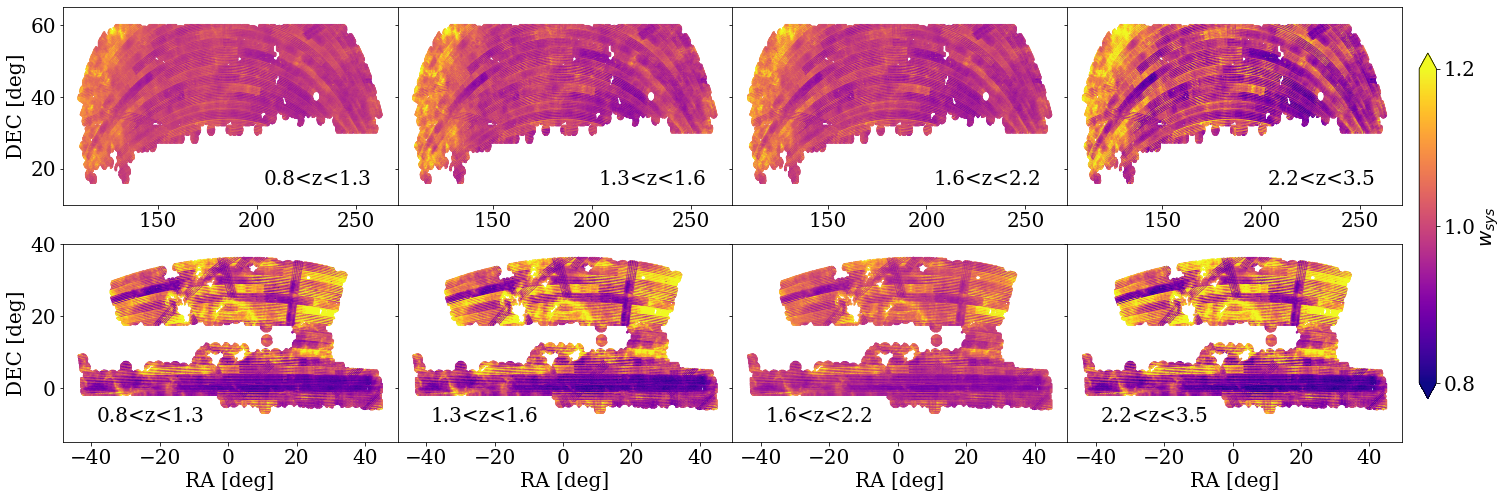

In [5]:
#pdf = matplotlib.backends.backend_pdf.PdfPages('figs/wsys_nn_known_p2_v7_2.pdf')
plt.rc('font', family='serif', size=20)

ncols = 4
fig, ax = plt.subplots(ncols=ncols, nrows=2, figsize=(6*ncols, 8), 
                       sharey='row', sharex='row')
fig.subplots_adjust(wspace=0.0)
ax= ax.flatten()

for j,cap in enumerate(['NGC', 'SGC']):
    
    path1 = '/home/mehdi/data/eboss/v7_2/0.3/results/'
    path2 = 'regression/nn_known/nn-weights.hp512.fits'
    wmaps = [path1 + f'{cap}_{z}_512/' + path2 for z in ['z1', 'z2', 'z3', 'zhigh']]


    # read maps
    dwmaps = []
    for wmap in wmaps:
        dwmaps.append(hp.read_map(wmap, verbose=False))


    zlims = [[0.8, 1.3], [1.3, 1.6], [1.6, 2.2], [2.2, 3.5]]



    kw = dict(vmax=1.2, vmin=0.8, cmap=plt.cm.plasma, marker='.', rasterized=True)

    for i,dwmap in enumerate(dwmaps):
        print('.', end='')

        ix = j*4+i
        
        hpix = np.argwhere(dwmap > 0).flatten()
        ra, dec = hpix2radec(512, hpix)

        mapi = ax[ix].scatter(shiftra(ra), dec, 1,
                    c=1/dwmap[hpix], **kw)

        if ix <4:
            ax[ix].set_ylim(10, 65)
            xtext = 0.6
        else:
            xtext = 0.1
            ax[ix].set_ylim(-15, 40)

        ax[ix].text(xtext, 0.1, '{}<z<{}'.format(*zlims[i]), 
                    color='k', transform=ax[ix].transAxes, fontsize=20)            
            
        if j==1:
            ax[ix].set(xlabel='RA [deg]') # title='{0}<z<{1}'.format(*zlim)

        if i==0:ax[ix].set(ylabel='DEC [deg]')

cax = plt.axes([0.91, 0.2, 0.01, 0.6])
cbar = fig.colorbar(mapi, cax=cax,
             shrink=0.7, ticks=[0.8, 1.0, 1.2], extend='both')
cbar.set_label(label=r'$w_{sys}$', size=20)
cbar.ax.tick_params(labelsize=20)

fig.savefig('figs/wsys_nn_known_p3_v7_2.pdf', bbox_inches='tight')
#pdf.savefig(1, bbox_inches='tight')    
#pdf.close()

# Clustering

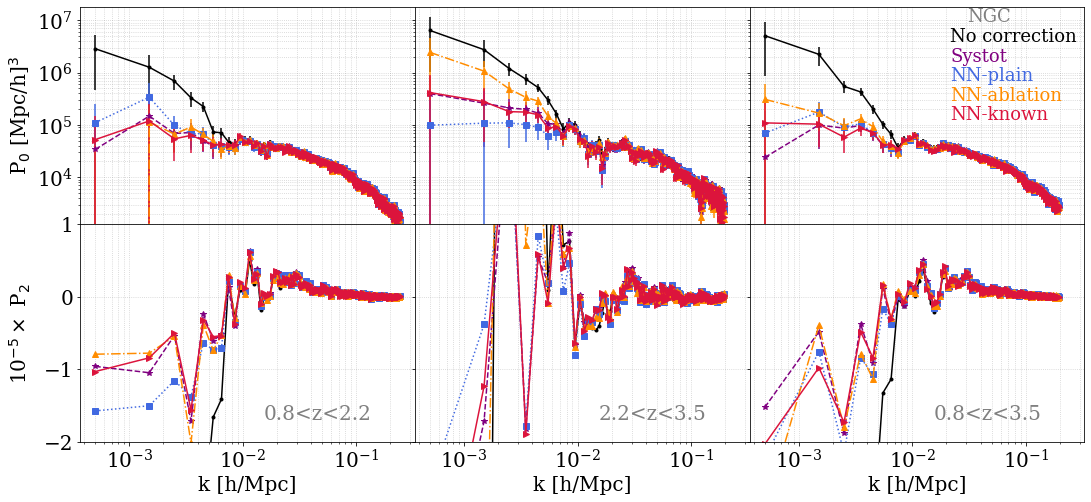

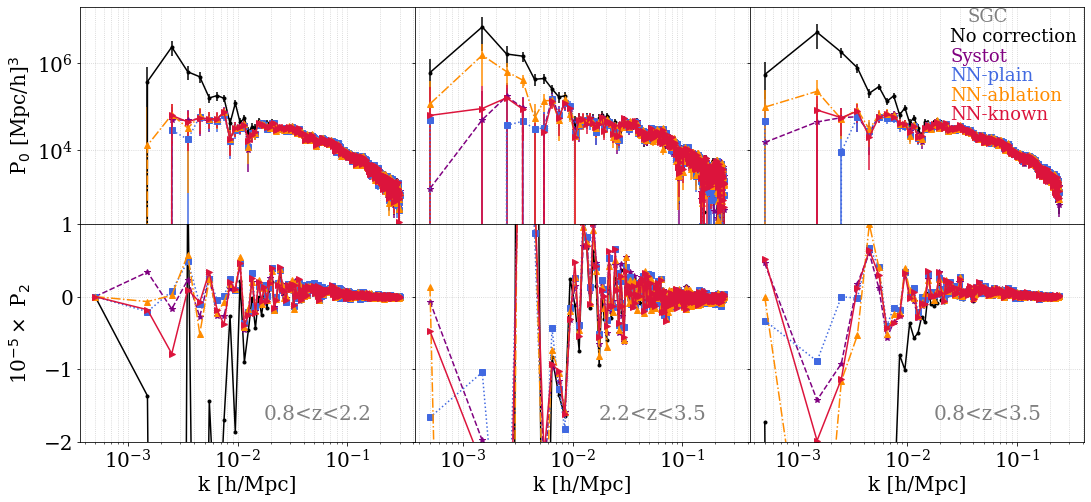

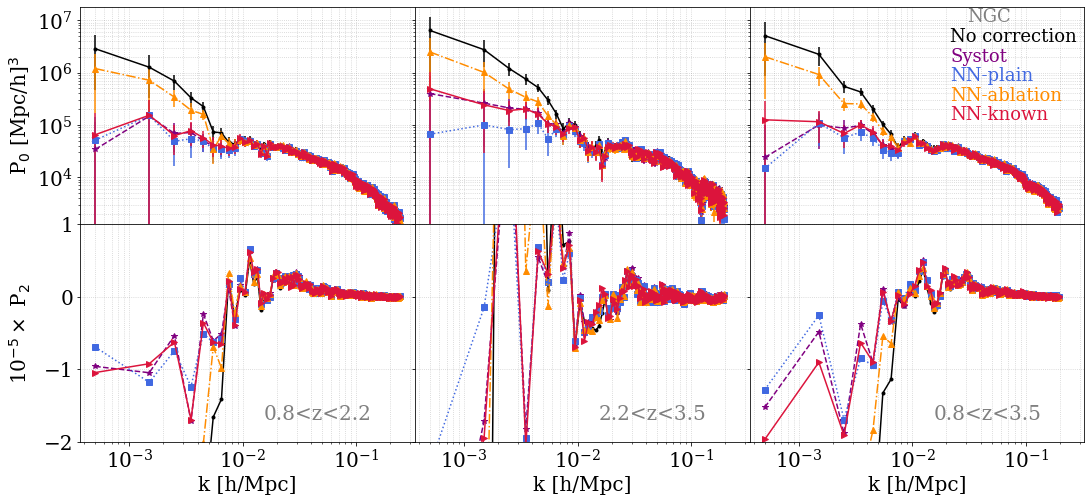

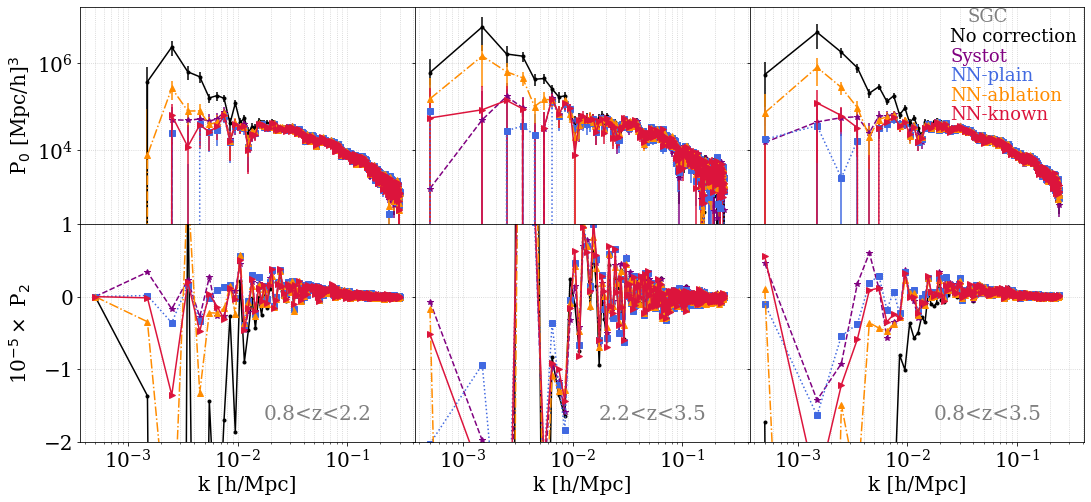

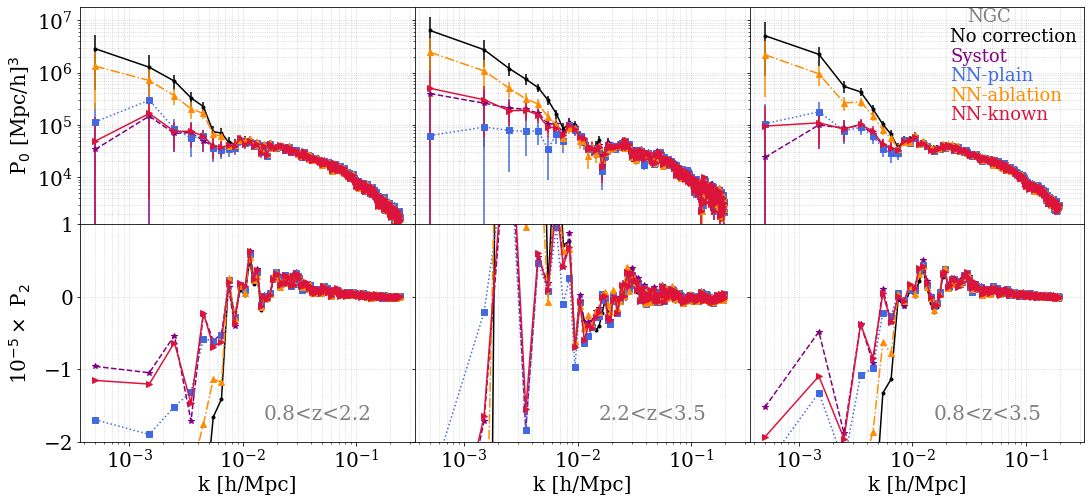

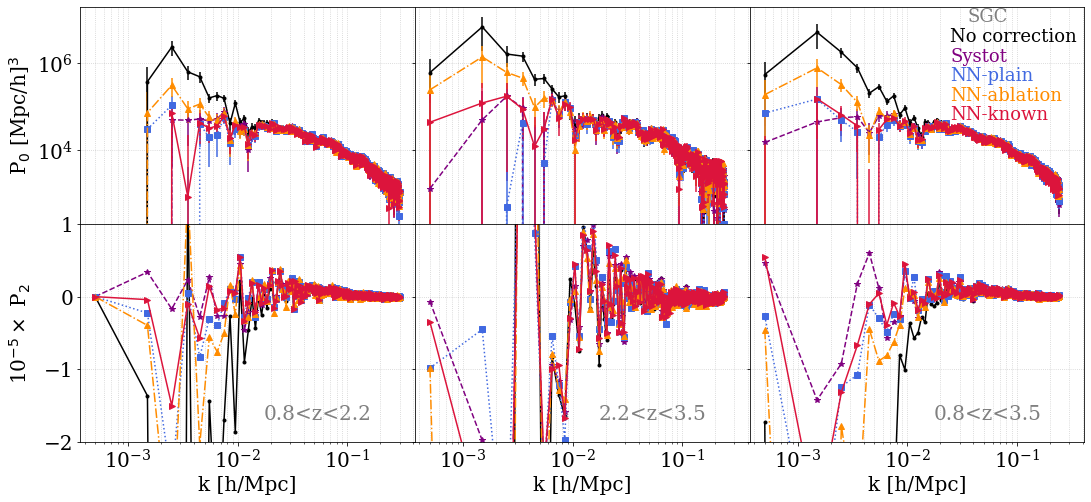

In [10]:
pdfname = 'figs/eboss_qso_v7_2_p3.pdf'

caps = ['NGC', 'SGC']
samples = ['standard', 'zhigh', 'combined']
treatments = ['No correction', 'Systot',   'NN-plain', 'NN-ablation', 'NN-known']

models2z  = ['wosystot', 'wsystot',  'plain_allhigh', 'ablation_allhigh', 'known_allhigh']
models3z  = ['wosystot', 'wsystot',  'plain_lowmidhigh', 'ablation_lowmidhigh', 'known_lowmidhigh']
models4z  = ['wosystot', 'wsystot',  'plain_z3high', 'ablation_z3high', 'known_z3high']

mk = ['.', '*', 's', '^', '>', 'o']
c = ['k', 'purple', 'royalblue', 'darkorange', 'crimson']
#c = [plt.cm.gnuplot(i/len(models)) for i in range(len(models))]

ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'
labels = {'standard':'0.8<z<2.2',
           'zhigh':'2.2<z<3.5',
          'combined':'0.8<z<3.5'} 



pdf = matplotlib.backends.backend_pdf.PdfPages(pdfname) 

pdf_i = 0
for k, models in enumerate([models2z, models3z, models4z]):
    
    for cap in caps:    
        fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), 
                               sharey='row', sharex=True)
        ax = ax.flatten()
        fig.subplots_adjust(wspace=0.0, hspace=0.0)

        for j, sample in enumerate(samples):

            for i,model in enumerate(models):
                
                kwargs = dict(label=treatments[i], ls=ls[i], c=c[i], marker=mk[i])
                
                pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))

                err = pk_i[:,2]/(0.5*pk_i[:,5])**0.5

                # monopole
                ax[j].errorbar(pk_i[:,0], pk_i[:,2]-shotnoise, yerr=err, **kwargs)

                # quadrupole
                #if (model=='wosystot') | ('ablation' in model):
                #    continue
                ax[j+3].errorbar(pk_i[:,0], pk_i[:,3]/1e5, **kwargs)

        ##-- cosmetics
        # redshifts
        for i, sample in enumerate(samples):
            ax[i+3].text(0.55, 0.1, 
                       labels[sample], 
                       color='grey',
                       transform=ax[i+3].transAxes)




        # labels
        ax[2].text(0.65, 0.93, cap.upper(), color='grey',
                   transform=ax[2].transAxes, fontsize=18)
        for i in range(len(models)):
            j == 2 # top right
            ax[j].text(0.6, 0.84-i*0.09, 
                       treatments[i], 
                       color=c[i], 
                       transform=ax[j].transAxes,
                       fontsize=18)

        # x-y axes labels
        for i, axi in enumerate(ax):
            axi.set(xscale='log')#, yscale='log')
            axi.grid(True, ls=':', color='grey', which='both', alpha=0.4)
            if i<3:
                axi.set_yscale('log')
                if i==0:
                    axi.set_ylabel(r'P$_{0}$ [Mpc/h]$^{3}$')
            else:
                axi.set(xlabel='k [h/Mpc]')
                if i==3:
                    axi.set_ylim(-2, 1)
                    axi.set_ylabel(r'10$^{-5} \times$ P$_{2}$')
        fig.align_labels()
        pdf.savefig((pdf_i+1), bbox_inches='tight')
        pdf_i += 1
pdf.close()  

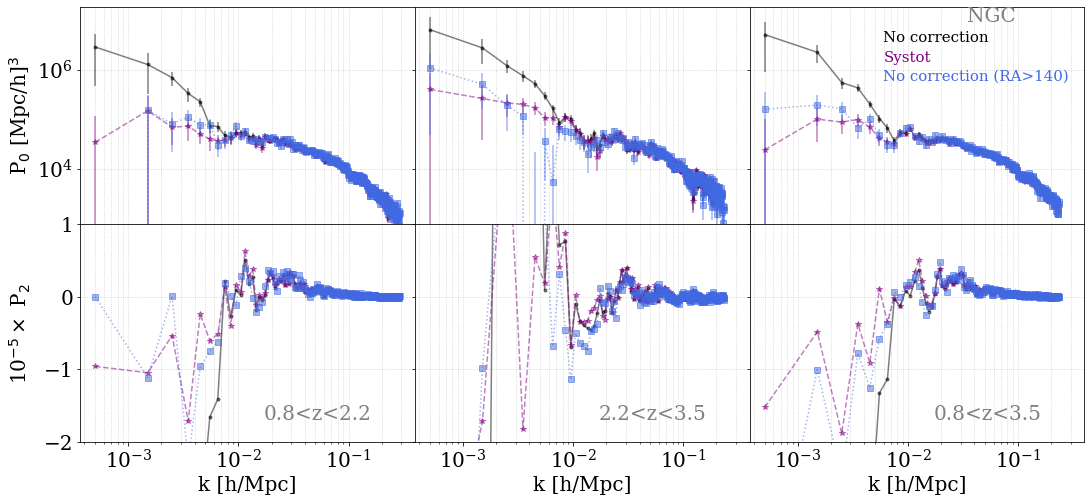

In [12]:
pdfname = 'figs/eboss_qso_v7_2_p3_ra_cut.pdf'

caps = ['NGC'] # only NGC makes sense
samples = ['standard', 'zhigh', 'combined']
treatments = ['No correction', 'Systot', 'No correction (RA>140)']
models  = ['wosystot', 'wsystot', 'wosystot_racut']
#treatments = ['No correction (RA cut)', 'Systot (RA cut)']
#models  = ['wosystot_racut', 'wsystot_racut']

mk = ['.', '*', 's', '^', '>', 'o']
c = ['k', 'purple', 'royalblue', 'purple']

ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'
labels = {'standard':'0.8<z<2.2',
           'zhigh':'2.2<z<3.5',
          'combined':'0.8<z<3.5'} 



pdf = matplotlib.backends.backend_pdf.PdfPages(pdfname) 
pdf_i = 0

for cap in caps:    
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), 
                           sharey='row', sharex=True)
    ax = ax.flatten()
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            err = pk_i[:,2]/(0.5*pk_i[:,5])**0.5
            
            # monopole
            ax[j].errorbar(pk_i[:,0], pk_i[:,2]-shotnoise,
                           yerr=err,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)
            
            # quadrupole
            ax[j+3].errorbar(pk_i[:,0], pk_i[:,3]/1e5,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)

    ##-- cosmetics
    ##-- cosmetics
    # redshifts
    for i, sample in enumerate(samples):
        ax[i+3].text(0.55, 0.1, 
                   labels[sample], 
                   color='grey',
                   transform=ax[i+3].transAxes)




    # labels
    ax[2].text(0.65, 0.93, cap.upper(), color='grey', transform=ax[2].transAxes)
    for i in range(len(models)):
        j == 2 # top right
        ax[j].text(0.4, 0.84-i*0.09, 
                   treatments[i], 
                   color=c[i], 
                   transform=ax[j].transAxes,
                   fontsize=15)

    # x-y axes labels
    for i, axi in enumerate(ax):
        axi.set(xscale='log')#, yscale='log')
        axi.grid(True, ls=':', color='grey', which='both', alpha=0.4)
        if i<3:
            axi.set_yscale('log')
            if i==0:
                axi.set_ylabel(r'P$_{0}$ [Mpc/h]$^{3}$')
        else:
            axi.set(xlabel='k [h/Mpc]')
            if i==3:
                axi.set_ylim(-2, 1)
                axi.set_ylabel(r'10$^{-5} \times$ P$_{2}$')
    fig.align_labels()
    pdf.savefig((pdf_i+1), bbox_inches='tight')
pdf.close()

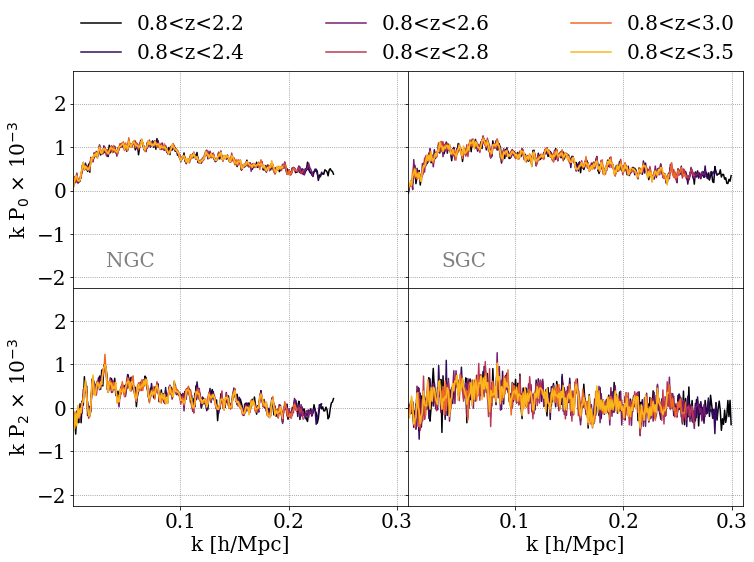

In [13]:
caps = ['NGC', 'SGC']
samples = ['standard', 'zextend2.4', 'zextend2.6', 'zextend2.8',  'zextend3.0', 'combined']
treatments = ['systot']
models  = ['wsystot']

mk = ['.', '*', 's', '^', '>', 'o']
c = [plt.cm.inferno(i/len(samples)) for i in range(len(samples))]
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'
labels = {'zhigh':'2.2<z<3.5',
          'standard':'0.8<z<2.2',
          'zextend2.4':'0.8<z<2.4',
          'zextend2.6':'0.8<z<2.6',
          'zextend2.8':'0.8<z<2.8',
          'zextend3.0':'0.8<z<3.0',
          'combined':'0.8<z<3.5'} 

legendkw = dict(ncol=3, frameon=False,
                 bbox_to_anchor=(0.0, 1.0, 2., 0.4), loc="lower left",
                 mode="expand", borderaxespad=0)

ncols=2
fig, ax = plt.subplots(ncols=ncols, nrows=2, figsize=(6*ncols, 8), 
                       sharey=True, sharex=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for k,cap in enumerate(caps):    

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            # quadrupole
            #positive = pk_i[:,3]>0
            ax[k].plot(pk_i[:,0], pk_i[:,0]*(pk_i[:,2]-shotnoise)/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            ax[k+2].plot(pk_i[:,0], pk_i[:,0]*pk_i[:,3]/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            
    
    ax[k].set(xlim=(0.0009, 0.31), ylim=(-2.25, 2.75))
    ax[k+2].set(xlim=(0.0009, 0.31), xlabel='k [h/Mpc]')#xscale='log')

    ax[k].grid(True, ls=':',   color='grey', which='major')
    ax[k+2].grid(True, ls=':', color='grey', which='major')
    
    if k==0:
        ax[k].legend(**legendkw)
    if k%2 == 0:
        ax[k].set_ylabel(r'k P$_{0}$ $\times$ 10$^{-3}$')
        ax[k+2].set_ylabel(r'k P$_{2}$ $\times$ 10$^{-3}$')
        
        
    ax[k].text(0.1, 0.1, cap.upper(), color='grey', transform=ax[k].transAxes)

fig.align_labels()
fig.savefig('figs/eboss_qso_v7_2_p3_standardzmax.pdf', bbox_inches='tight')

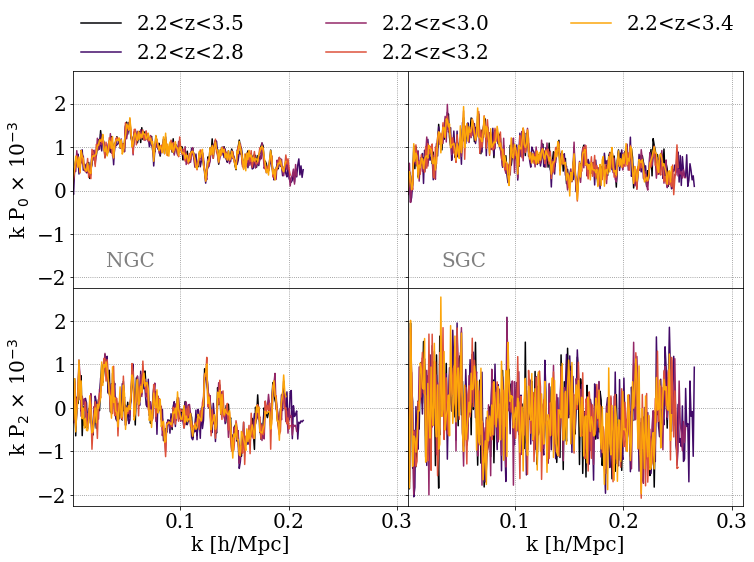

In [14]:
caps = ['NGC', 'SGC']
samples = ['zhigh', 'hizextend2.8', 'hizextend3.0', 'hizextend3.2', 'hizextend3.4']
treatments = ['systot']
models  = ['wsystot']

mk = ['.', '*', 's', '^', '>', 'o']
c = [plt.cm.inferno(i/len(samples)) for i in range(len(samples))]
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'
labels = {'zhigh':'2.2<z<3.5',
          'standard':'0.8<z<2.2',
          'zextend2.4':'0.8<z<2.4',
          'zextend2.6':'0.8<z<2.6',
          'zextend2.8':'0.8<z<2.8',
          'zextend3.0':'0.8<z<3.0',
          'combined':'0.8<z<3.5',
         'hizextend2.8':'2.2<z<2.8',
         'hizextend3.0':'2.2<z<3.0',          
         'hizextend3.2':'2.2<z<3.2',
         'hizextend3.4':'2.2<z<3.4'} 

legendkw = dict(ncol=3, frameon=False,
                 bbox_to_anchor=(0.0, 1.0, 2., 0.4), loc="lower left",
                 mode="expand", borderaxespad=0)

ncols=2
fig, ax = plt.subplots(ncols=ncols, nrows=2, figsize=(6*ncols, 8), 
                       sharey=True, sharex=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for k,cap in enumerate(caps):    

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            # quadrupole
            #positive = pk_i[:,3]>0
            ax[k].plot(pk_i[:,0], pk_i[:,0]*(pk_i[:,2]-shotnoise)/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            ax[k+2].plot(pk_i[:,0], pk_i[:,0]*pk_i[:,3]/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            
    
    ax[k].set(xlim=(0.0009, 0.31), ylim=(-2.25, 2.75))
    ax[k+2].set(xlim=(0.0009, 0.31), xlabel='k [h/Mpc]')

    ax[k].grid(True, ls=':',   color='grey', which='major')
    ax[k+2].grid(True, ls=':', color='grey', which='major')
    
    if k==0:
        ax[k].legend(**legendkw)
    if k%2 == 0:
        ax[k].set_ylabel(r'k P$_{0}$ $\times$ 10$^{-3}$')
        ax[k+2].set_ylabel(r'k P$_{2}$ $\times$ 10$^{-3}$')
        
        
    ax[k].text(0.1, 0.1, cap.upper(), color='grey', transform=ax[k].transAxes)

fig.align_labels()
fig.savefig('figs/eboss_qso_v7_2_p3_highzzmax.pdf', bbox_inches='tight')

# mocks

In [18]:
path = '/B/Shared/mehdi/eboss/mocks/0.3/'
pk_dict = {}

for cont in ['null', 'contaminated']:
    for model in ['ablation', 'known', 'plain', 'nowsys', 'systot', 'truth']:
        
        if (cont == 'null') & (model == 'nowsys'):
            continue
        
        if (cont == 'contaminated') & (model == 'truth'):
            continue
        
        for zsplit in ['all', 'lowmid', 'z3']:
            
            if (model in ['nowsys', 'systot', 'truth']) & (zsplit != 'all'):
                continue
            
            pk0 = []
            pk2 = []
            
            for i in range(1,9):                
                pktxt = f'{path}NGC_{i:04d}_{cont}/pk_QSO_NGC_v7_0.3_{model}_{zsplit}_{i:04d}_{cont}_512_standard.txt'

                pkdata, shotnoise = readnbodykit(pktxt)
                pk0.append(pkdata[:,2]-shotnoise)
                pk2.append(pkdata[:,3])
            
            name = '_'.join([cont, model, zsplit])
            pk_dict[name] = (pkdata[:, 0], np.mean(pk0, axis=0), np.mean(pk2, axis=0))
            print(name)

null_ablation_all
null_ablation_lowmid
null_ablation_z3
null_known_all
null_known_lowmid
null_known_z3
null_plain_all
null_plain_lowmid
null_plain_z3
null_systot_all
null_truth_all
contaminated_ablation_all
contaminated_ablation_lowmid
contaminated_ablation_z3
contaminated_known_all
contaminated_known_lowmid
contaminated_known_z3
contaminated_plain_all
contaminated_plain_lowmid
contaminated_plain_z3
contaminated_nowsys_all
contaminated_systot_all


In [19]:
len(pk_dict.keys())

22

In [20]:
colors = {}
for i, key in enumerate(pk_dict.keys()):
    colors[key] = plt.cm.jet(i/22)

In [21]:
plt.rc('axes', facecolor='#fafafa')

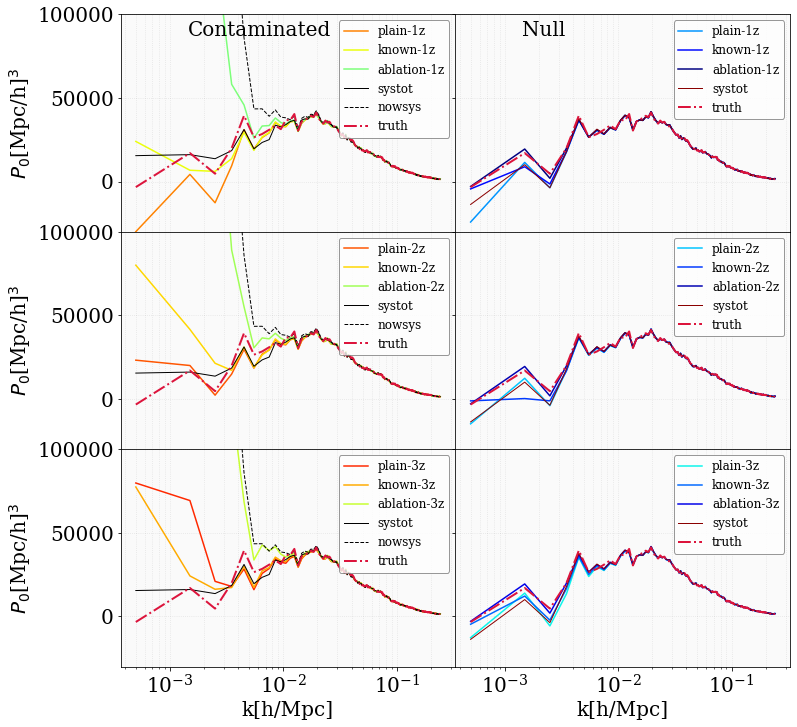

In [22]:
fig, ax = plt.subplots(ncols=2, 
                       nrows=3,
                       figsize=(12, 12), 
                       sharey=True, sharex=True)
ax = ax.flatten()
fig.subplots_adjust(hspace=0, wspace=0)


# -- draw the nn-based
zsplits_l = {'all':'1z',
             'lowmid':'2z',
             'z3':'3z'}

zsplits= ['all', 'lowmid', 'z3']
for j,zsplit in enumerate(zsplits):
    
    for i, model in enumerate(['plain', 'known', 'ablation']):
        ix = 2*j
        
        label = '-'.join([model, zsplits_l[zsplit]])
        name = f'contaminated_{model}_{zsplit}'
        ax[ix].plot(pk_dict[name][0], pk_dict[name][1], color=colors[name], label=label)

        name = f'null_{model}_{zsplit}'
        ax[ix+1].plot(pk_dict[name][0], pk_dict[name][1], color=colors[name], label=label)       

for j in range(3):
    ix = 2*j        
    
    name = f'contaminated_systot_all'
    ax[ix].plot(pk_dict[name][0], pk_dict[name][1], color='k', label='systot', lw=1)
    name = f'contaminated_nowsys_all'
    ax[ix].plot(pk_dict[name][0], pk_dict[name][1], color='k', label='nowsys', ls='--', lw=1)
    

    name = f'null_systot_all'
    ax[ix+1].plot(pk_dict[name][0], pk_dict[name][1], color='#8a0000', label='systot', lw=1)
    
    name = f'null_truth_all'
    kw = dict(color='crimson',  label='truth', ls='-.', lw=2)
    ax[ix].plot(pk_dict[name][0], pk_dict[name][1], **kw)    
    ax[ix+1].plot(pk_dict[name][0], pk_dict[name][1], **kw)

       
for i, axi in enumerate(ax):
    axi.set_xscale('log')
    axi.set_ylim(-3.0e4, 1.0e5)
    axi.grid(True, ls=':', color='grey', alpha=0.2, which='both')
    axi.legend(loc='upper right', fontsize=12, facecolor='w', edgecolor='grey')
    
    if i%2==0:
        axi.set_ylabel(r'$P_{0}$[Mpc/h]$^{3}$')
        
    if i > 3:
        axi.set_xlabel(r'k[h/Mpc]')
    

for i, cont in enumerate(['Contaminated', 'Null']):
    ax[i].text(0.2, 0.9, cont, transform=ax[i].transAxes)

In [19]:
import nbodykit.lab as nb

In [26]:
d1 = nb.ConvolvedFFTPower.load('/home/mehdi/data/eboss/mocks/pks/pk_NGC_null_v7_noweight_512_0001.json')
d2 = nb.ConvolvedFFTPower.load('/B/Shared/mehdi/eboss/mocks/NGC_0001_null/pk_QSO_NGC_v7_0.2_truth_all_0001_null_512_standard.json')

In [27]:
d1.poles['power_0'].real[:10]

array([ 17728.854,  27331.34 ,  70114.21 ,  85256.54 , 122136.22 ,
       101369.36 ,  96271.5  , 103143.84 ,  97346.055,  85396.68 ],
      dtype=float32)

In [28]:
d2.poles['power_0'].real[:10]

array([ 17728.854,  27331.34 ,  70114.21 ,  85256.54 , 122136.22 ,
       101369.36 ,  96271.5  , 103143.84 ,  97346.055,  85396.68 ],
      dtype=float32)

In [2]:
from glob import glob

In [62]:
dnulls = glob('/B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/EZmock_eBOSS_QSO_NGC_v7_0.2_*.dat.fits')
rnulls = glob('/B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/EZmock_eBOSS_QSO_NGC_v7_0.2_*.ran.fits')

In [17]:
mock_1 = ft.read('/B/Shared/mehdi/eboss/mocks/NGC_0001_contaminated/EZmock_eBOSS_QSO_NGC_v7_0.2_plain_lowmid_0001.dat.fits')
mock_9 = ft.read('/B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/EZmock_eBOSS_QSO_NGC_v7_0.2_plain_lowmid_0009.dat.fits')

In [11]:
mock_9['WEIGHT_SYSTOT'].min()

0.7458633057982792

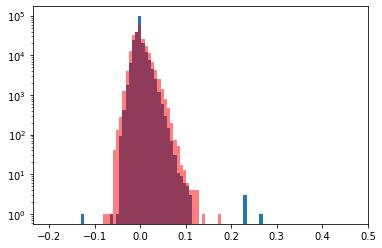

In [24]:
plt.hist(np.log10(mock_9['WEIGHT_SYSTOT']), bins=100, range=(-0.2, 0.5))
plt.hist(np.log10(mock_1['WEIGHT_SYSTOT']), bins=100, range=(-0.2, 0.5),
         color='r', alpha=0.5)
plt.xlim(xmax=0.5)
plt.yscale('log')

In [27]:
for cutoff in [2, 3, 5, 10]:
    print(cutoff, (mock_9['WEIGHT_SYSTOT'] > cutoff).sum())

2 3
3 3
5 3
10 2


In [24]:
pk1 = readnbodykit('/B/Shared/mehdi/eboss/mocks/0.3/NGC_0001_contaminated/pk_QSO_NGC_v7_0.3_plain_lowmid_0001_contaminated_512_standard.txt')
pk9 = readnbodykit('/B/Shared/mehdi/eboss/mocks/0.3/NGC_0009_contaminated/pk_QSO_NGC_v7_0.3_plain_lowmid_0009_contaminated_512_standard.txt')

In [25]:
pk1[0].shape

(242, 6)

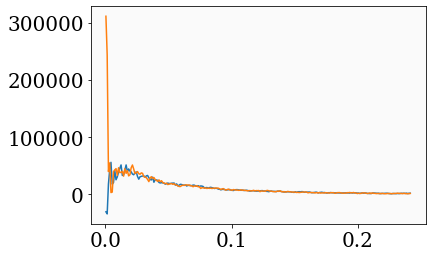

In [26]:

for pki in [pk1, pk9]:
    plt.plot(pki[0][:,0], pki[0][:, 2]-pki[1])

In [21]:
for mi in [mock_1, mock_9]:
    m = mi['WEIGHT_SYSTOT'] < 3.0
    print(mi['WEIGHT_SYSTOT'][m].sum())

219457.98883787973
219146.3913837305


In [137]:
print('%50s %6s %6s %6s %6s'%('name', 'num', 'weighted num', 'min wsys', 'max wsys'))
for null_i in dnulls:
    d_i = ft.read(null_i)
    w = d_i['WEIGHT_SYSTOT']*d_i['WEIGHT_NOZ']*d_i['WEIGHT_FKP']*d_i['WEIGHT_CP']
    print('%60s %6d %6.1f %.3f %.3f'%(null_i.split('/')[-1], d_i.size, w.sum(), *np.percentile(d_i['WEIGHT_SYSTOT'], [0, 100])))

                                              name    num weighted num min wsys max wsys
      EZmock_eBOSS_QSO_NGC_v7_0.2_plain_lowmid_0009.dat.fits 219550 197946.2 0.746 449.290
         EZmock_eBOSS_QSO_NGC_v7_0.2_plain_all_0009.dat.fits 219550 197354.4 0.876 1.285
          EZmock_eBOSS_QSO_NGC_v7_0.2_plain_z3_0009.dat.fits 219550 197477.8 0.833 19.308
      EZmock_eBOSS_QSO_NGC_v7_0.2_known_lowmid_0009.dat.fits 219550 197467.8 0.871 2.177
         EZmock_eBOSS_QSO_NGC_v7_0.2_known_all_0009.dat.fits 219550 197583.7 0.860 1.239
          EZmock_eBOSS_QSO_NGC_v7_0.2_known_z3_0009.dat.fits 219550 197440.3 0.850 2.095
   EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_lowmid_0009.dat.fits 219550 197351.9 0.892 1.312
      EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_all_0009.dat.fits 219550 197633.0 0.888 1.193
       EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_z3_0009.dat.fits 219550 197573.1 0.867 1.368


In [106]:
for null_i in rnulls:
    d_i = ft.read(null_i)
    w = d_i['WEIGHT_SYSTOT']*d_i['WEIGHT_NOZ']*d_i['WEIGHT_FKP']*d_i['WEIGHT_CP']
    print('%60s %6d %6.1f %.3f %.3f'%(null_i.split('/')[-1], d_i.size, w.sum(), *np.percentile(d_i['WEIGHT_SYSTOT'], [0, 100])))

      EZmock_eBOSS_QSO_NGC_v7_0.2_plain_lowmid_0009.ran.fits 3961799 3496565.8 0.460 449.290
         EZmock_eBOSS_QSO_NGC_v7_0.2_plain_all_0009.ran.fits 3961799 3483091.4 0.458 1.285
          EZmock_eBOSS_QSO_NGC_v7_0.2_plain_z3_0009.ran.fits 3961799 3485335.1 0.453 19.308
      EZmock_eBOSS_QSO_NGC_v7_0.2_known_lowmid_0009.ran.fits 3961799 3485044.1 0.458 2.177
         EZmock_eBOSS_QSO_NGC_v7_0.2_known_all_0009.ran.fits 3961799 3487030.7 0.467 1.239
          EZmock_eBOSS_QSO_NGC_v7_0.2_known_z3_0009.ran.fits 3961799 3484585.0 0.450 2.095
   EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_lowmid_0009.ran.fits 3961799 3482956.2 0.465 1.312
      EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_all_0009.ran.fits 3961799 3487950.2 0.467 1.193
       EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_z3_0009.ran.fits 3961799 3486859.3 0.467 1.368


In [65]:
def hist(data):
    kw1 = dict(range=(0.7, 3.6), bins=100, density=True)#, alpha=0.8, histtype='step')
    wt = data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ']*data['WEIGHT_SYSTOT']        
    #for name in ['CP', 'FKP', 'NOZ', 'SYSTOT']:
    #    print(name, data[f'WEIGHT_{name}'].min(), data[f'WEIGHT_{name}'].max())
    return np.histogram(data['Z'], weights=wt, **kw1) 

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0 /B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/EZmock_eBOSS_QSO_NGC_v7_0.2_plain_lowmid_0009.ran.fits


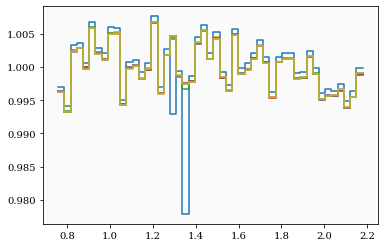

In [78]:
for i in range(9):
    d_i = ft.read(dnulls[i])
    #j = 6 if i == 0 else i        
    r_i = ft.read(rnulls[i])
    ##w = d_i['WEIGHT_SYSTOT']*d_i['WEIGHT_NOZ']*d_i['WEIGHT_FKP']*d_i['WEIGHT_CP']
    h,x = hist(d_i)
    hr,xr = hist(r_i)
    ratio = h/hr
    if np.any(ratio < 0.99):
        print(i, rnulls[i])
    plt.step(x[:-1], h/hr)

In [90]:
more /B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/log_contaminated_0009.txt

In [88]:
ls /B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/

EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_all_0009.dat.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_all_0009.ran.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_lowmid_0009.dat.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_lowmid_0009.ran.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_z3_0009.dat.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_ablation_z3_0009.ran.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_known_all_0009.dat.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_known_all_0009.ran.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_known_lowmid_0009.dat.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_known_lowmid_0009.ran.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_known_z3_0009.dat.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_known_z3_0009.ran.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_plain_all_0009.dat.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_plain_all_0009.ran.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_plain_lowmid_0009.dat.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_plain_lowmid_0009.ran.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_plain_z3_0009.dat.fits
EZmock_eBOSS_QSO_NGC_v7_0.2_plain_z3_0009.ran.fits
log_contaminated_0009.txt
ngal_fea

In [91]:
hpix = ft.read('/B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/results/NGC_low_512/regression/nn_plain/nn-weights512.fits')

In [93]:
hpix = hpix['hpind']

In [3]:
weights = glob('/B/Shared/mehdi/eboss/mocks/NGC_*/results/NGC_*_512/regression/nn_plain/nn-weights.hp512.fits')
tweights = glob('/B/Shared/mehdi/eboss/mocks/NGC_*/results/NGC_*_512/regression/nn_plain/nn-weights512.fits')

In [195]:
for w in tweights:
    d = ft.read(w)
    medians = np.mean(d['weight'], axis=1)
    ws = w.split('/')
    a, b = ws[-6], ws[-4]
    print('%40s %7.3f %.3f'%(a+'_'+b, *np.percentile(medians, [0, 100])))

       NGC_0001_contaminated_NGC_low_512   0.887 1.080
      NGC_0001_contaminated_NGC_high_512   0.894 1.058
       NGC_0001_contaminated_NGC_all_512   0.903 1.060
        NGC_0001_contaminated_NGC_z1_512   0.883 1.075
        NGC_0001_contaminated_NGC_z2_512   0.945 1.051
        NGC_0001_contaminated_NGC_z3_512   0.899 1.067
               NGC_0001_null_NGC_low_512   0.984 1.011
              NGC_0001_null_NGC_high_512   0.984 1.021
               NGC_0001_null_NGC_all_512   0.980 1.022
                NGC_0001_null_NGC_z1_512   0.989 1.016
                NGC_0001_null_NGC_z2_512   0.943 1.068
                NGC_0001_null_NGC_z3_512   0.966 1.052
       NGC_0002_contaminated_NGC_low_512   0.909 1.068
      NGC_0002_contaminated_NGC_high_512   0.926 1.075
       NGC_0002_contaminated_NGC_all_512   0.934 1.059
        NGC_0002_contaminated_NGC_z1_512   0.877 1.100
        NGC_0002_contaminated_NGC_z2_512   0.938 1.068
        NGC_0002_contaminated_NGC_z3_512   0.927 1.083
          

In [108]:
data = ft.read(dnulls[0])

In [154]:
path = '/B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/'
path_org = '/B/Shared/eBOSS/contaminated/'
path_org_n = '/B/Shared/eBOSS/null/'

true_mock = ft.read(f'{path_org_n}EZmock_eBOSS_QSO_NGC_v7_noweight_0009.dat.fits')
org_mock = ft.read(f'{path_org}EZmock_eBOSS_QSO_NGC_v7_0009.dat.fits')
bad_mock = ft.read(f'{path}EZmock_eBOSS_QSO_NGC_v7_0.2_plain_lowmid_0009.dat.fits')
good_mock = ft.read(f'{path}EZmock_eBOSS_QSO_NGC_v7_0.2_plain_all_0009.dat.fits')

In [155]:
true_mock.size, good_mock.size

(232002, 219550)

In [146]:
bad_weights = bad_mock['WEIGHT_SYSTOT'] > 2
bad_mock[bad_weights]

array([(238.220651, 56.029351, 1.1128317, 0.83552293, 1.03968219, 1., 1.96855250e-05,   6.25794628),
       (238.5325  , 42.960248, 1.39541  , 0.83741606, 1.04870251, 1., 1.94149530e-05, 449.29032325),
       (238.553354, 42.948932, 1.3346794, 0.82310934, 1.04786554, 1., 2.14905422e-05, 449.29032325)],
      dtype=[('RA', '>f8'), ('DEC', '>f8'), ('Z', '>f8'), ('WEIGHT_FKP', '>f8'), ('WEIGHT_NOZ', '>f8'), ('WEIGHT_CP', '>f8'), ('NZ', '>f8'), ('WEIGHT_SYSTOT', '>f8')])

In [147]:
org_mock[bad_weights]

array([(238.220651, 56.029351, 1.1128317, 0.83552293, 1.03968219, 1., 1.96855250e-05, 1.25561126),
       (238.5325  , 42.960248, 1.39541  , 0.83741606, 1.04870251, 1., 1.94149530e-05, 1.28314305),
       (238.553354, 42.948932, 1.3346794, 0.82310934, 1.04786554, 1., 2.14905422e-05, 1.28314305)],
      dtype=[('RA', '>f8'), ('DEC', '>f8'), ('Z', '>f8'), ('WEIGHT_FKP', '>f8'), ('WEIGHT_NOZ', '>f8'), ('WEIGHT_CP', '>f8'), ('NZ', '>f8'), ('WEIGHT_SYSTOT', '>f8')])

In [157]:
true_ra_dec = (np.abs(true_mock['RA']-238.5) < 0.1) & (np.abs(true_mock['DEC']-42.9) < 0.1) 
bad_ra_dec = (np.abs(bad_mock['RA']-238.5) < 0.1) & (np.abs(bad_mock['DEC']-42.9) < 0.1)
bad_mock[ra_dec], true_mock[true_ra_dec]

(array([(238.5325  , 42.960248, 1.39541  , 0.83741606, 1.04870251, 1., 1.94149530e-05, 449.29032325),
        (238.553354, 42.948932, 1.3346794, 0.82310934, 1.04786554, 1., 2.14905422e-05, 449.29032325),
        (238.480598, 42.981501, 1.9445948, 0.86739795, 1.04870251, 1., 1.52873369e-05,   0.99489677)],
       dtype=[('RA', '>f8'), ('DEC', '>f8'), ('Z', '>f8'), ('WEIGHT_FKP', '>f8'), ('WEIGHT_NOZ', '>f8'), ('WEIGHT_CP', '>f8'), ('NZ', '>f8'), ('WEIGHT_SYSTOT', '>f8')]),
 array([(238.5325  , 42.960248, 1.39541  , 0.89597201, 1., 1., 1.93510493e-05, 1.),
        (238.480598, 42.981501, 1.9445948, 0.91502595, 1., 1., 1.54775306e-05, 1.)],
       dtype=[('RA', '>f8'), ('DEC', '>f8'), ('Z', '>f8'), ('WEIGHT_FKP', '>f8'), ('WEIGHT_NOZ', '>f8'), ('WEIGHT_CP', '>f8'), ('NZ', '>f8'), ('WEIGHT_SYSTOT', '>f8')]))

In [152]:
org_mock[ra_dec]

array([(238.5325  , 42.960248, 1.39541  , 0.83741606, 1.04870251, 1., 1.94149530e-05, 1.28314305),
       (238.553354, 42.948932, 1.3346794, 0.82310934, 1.04786554, 1., 2.14905422e-05, 1.28314305),
       (238.480598, 42.981501, 1.9445948, 0.86739795, 1.04870251, 1., 1.52873369e-05, 1.00870803)],
      dtype=[('RA', '>f8'), ('DEC', '>f8'), ('Z', '>f8'), ('WEIGHT_FKP', '>f8'), ('WEIGHT_NOZ', '>f8'), ('WEIGHT_CP', '>f8'), ('NZ', '>f8'), ('WEIGHT_SYSTOT', '>f8')])

In [153]:
good_mock[ra_dec]

array([(238.5325  , 42.960248, 1.39541  , 0.83741606, 1.04870251, 1., 1.94149530e-05, 1.04774474),
       (238.553354, 42.948932, 1.3346794, 0.82310934, 1.04786554, 1., 2.14905422e-05, 1.04774474),
       (238.480598, 42.981501, 1.9445948, 0.86739795, 1.04870251, 1., 1.52873369e-05, 0.98817326)],
      dtype=[('RA', '>f8'), ('DEC', '>f8'), ('Z', '>f8'), ('WEIGHT_FKP', '>f8'), ('WEIGHT_NOZ', '>f8'), ('WEIGHT_CP', '>f8'), ('NZ', '>f8'), ('WEIGHT_SYSTOT', '>f8')])

In [138]:
bad_data = data[data['WEIGHT_SYSTOT']>3]
bad_data

array([(238.220651, 56.029351, 1.1128317, 0.83552293, 1.03968219, 1., 1.96855250e-05,   6.25794628),
       (238.5325  , 42.960248, 1.39541  , 0.83741606, 1.04870251, 1., 1.94149530e-05, 449.29032325),
       (238.553354, 42.948932, 1.3346794, 0.82310934, 1.04786554, 1., 2.14905422e-05, 449.29032325)],
      dtype=[('RA', '>f8'), ('DEC', '>f8'), ('Z', '>f8'), ('WEIGHT_FKP', '>f8'), ('WEIGHT_NOZ', '>f8'), ('WEIGHT_CP', '>f8'), ('NZ', '>f8'), ('WEIGHT_SYSTOT', '>f8')])

In [119]:
from LSSutils.utils import radec2hpix

In [121]:
hpix_bad = radec2hpix(512, bad_data['RA'], bad_data['DEC'])
hpix_bad

array([500325, 500325])

In [129]:
t

array([(624623, [1.0026918 , 1.00286222, 1.00330327, 1.00399562, 1.00267341, 1.00273436, 1.00248964, 1.00284556, 1.00311524, 1.00292183]),
       (297844, [1.00289868, 1.00542758, 1.00544384, 1.00198932, 1.00153214, 1.00531237, 1.00500243, 1.00546343, 1.0051366 , 1.00556305]),
       (788158, [0.93949381, 0.94217086, 0.94234384, 0.94177619, 0.94446758, 0.94200007, 0.94245302, 0.94181894, 0.94148679, 0.94154447]),
       ...,
       (244859, [0.95723154, 0.95146299, 0.94705758, 0.95622792, 0.95385607, 0.94912387, 0.94879108, 0.9492855 , 0.950052  , 0.9481895 ]),
       (376423, [0.95492384, 0.94972049, 0.95437627, 0.95811989, 0.95707549, 0.95308197, 0.95710275, 0.96286863, 0.94986677, 0.95412146]),
       (493817, [1.06369802, 1.05856878, 1.06713995, 1.05469758, 1.05371246, 1.06164085, 1.06619256, 1.05580086, 1.0573714 , 1.06118253])],
      dtype=[('hpind', '>i8'), ('weight', '>f8', (10,))])

In [173]:
for i in range(len(weights)):
    d = hp.read_map(weights[i], verbose=False)
    t = ft.read(tweights[i])
    
    m = np.in1d(t['hpind'], hpix_bad)
    print(weights[i].split('/')[-4], d[hpix_bad], t['weight'][m],
          np.median(t['weight'][m]), np.mean(t['weight'][m]), 1/np.mean(t['weight'][m]))
    print()
    for ti in t['weight'][m].tolist()[0]:
        print('%.3f'%ti, end=' ')
    print()
    print('%.4f %.3f'%(np.median(t['weight'][m]), 1/np.median(t['weight'][m])))

NGC_low_512 [0.00222573 0.00222573] [[-0.35557154  0.00765193 -0.0897353  -0.35541127  0.30794249 -0.02868499
   0.319997   -0.00320047  0.32956056  0.32825942]] 0.0022257323344105906 0.04608078335563524 21.70101997360489

-0.356 0.008 -0.090 -0.355 0.308 -0.029 0.320 -0.003 0.330 0.328 
0.0022 449.290
NGC_high_512 [0.45838991 0.45838991] [[0.64341613 0.44780781 0.52764933 0.41514805 0.43330629 0.49883188
  0.45243249 0.49416962 0.45217914 0.46434732]] 0.45838990655204676 0.4829288063036721 2.070698593554568

0.643 0.448 0.528 0.415 0.433 0.499 0.452 0.494 0.452 0.464 
0.4584 2.182
NGC_all_512 [0.95443094 0.95443094] [[0.9481969  1.0221265  0.69568732 1.06102971 0.8742815  0.96119559
  0.96066498 0.91152649 1.00160286 0.72504338]] 0.9544309423450398 0.9161355232147901 1.0915415619851996

0.948 1.022 0.696 1.061 0.874 0.961 0.961 0.912 1.002 0.725 
0.9544 1.048
NGC_z1_512 [0.72247517 0.72247517] [[-0.01097718  0.80836935  0.70739445  0.79866988  0.73755589  0.02908415
   0.70552204  0.0